## Part 1: Preprocessing of the Database
Since the provided dataset is not "ready-to-use", it needs to be handled so it could be used further safely. 

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df_or = pd.read_excel('Cities.xls', index_col=0, skipinitialspace=True) # Read with excel index. 
# Skip all white-spaces.

df = df_or.set_index('cityID') # Remove the indices and use cityID as index.

# Drop unnecessary columns (that explicitly imply each other)
# cityID implies City, and Country
# clusterID implies Typology
# Pollution Index is restricted to be used in prediction.
col2drop = ['Country', 'City', 'Typology', 'Pollution Index ']


df.drop(columns=col2drop, inplace=True)# Typology <=> clusterID, City <=> cityID, 

In [72]:
df = df.replace(r'^\s*$', np.NaN, regex=True)
print("Initial dataframe shape [rows, columns]:", df.shape)
n_NaN = df.isna().sum().sum()
print(n_NaN) # As you can see the total number of NaNs in the database 3199, so we need to impute.

# Impute all NaNs over the database.

df_int = df.select_dtypes(include='integer')
df_float = df.select_dtypes(include='float')

df_int = df_int.fillna(df.mode().iloc[0]) # Try using mean/mod for different columns.
df_float = df_float.fillna(df.mean().iloc[0]) # Try using mean/mod for different columns.

df[df_int.columns.values.tolist()] = df_int # Use mod for integers,
df[df_float.columns.values.tolist()] = df_float # Use mean for floats


Initial dataframe shape [rows, columns]: (331, 73)
3040


In [167]:
# Reseting dataset.
df_or = pd.read_excel('FINAL-COMBINED-DATASET.xlsx', index_col=0, skipinitialspace=True) # Read with excel index. 
# Skip all white-spaces.
df = df_or.set_index('cityID') # Remove the indices and use cityID as index.
# df.info()
# Drop unnecessary columns (that explicitly imply each other)
# cityID implies City, and Country
# clusterID implies Typology
# Pollution Index is restricted to be used in prediction.
col2drop = ['Country', 'Typology', 'Pollution Index ']
df.drop(columns=col2drop, inplace=True)# Typology <=> clusterID, City <=> cityID, 
df = df.replace(r'^\s*$', np.NaN, regex=True)
print("Initial dataframe shape [rows, columns]:", df.shape)
n_NaN = df.isna().sum().sum()
print("Current total NaN values:", n_NaN) # As you can see the total number of NaNs in the database 3199, so we need to impute.
# Impute all NaNs over the database.
df_int = df.select_dtypes(include='integer')
df_float = df.select_dtypes(include='float')
# df.info() 


Initial dataframe shape [rows, columns]: (331, 73)
Current total NaN values: 3040


In [131]:
#df.info() # To see how many missing values each column has

In [137]:
# If more than 1/3 of the values are missing the column is dropped. i.e. should be atleast 331*(2/3)=218 non-null values.
# df2 = df.drop(['Car Modeshare (%)', 'Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)', 'Congestion (%)','Congestion AM Peak (%)','Congestion PM Peak (%)', 'Traffic Index', 'Travel Time Index', 'Inefficiency Index', 'Unemployment Rate (%)', 'Poverty Rate (%)', 'Safety Index'], axis=1)
# df = df.drop(['Car Modeshare (%)', 'Car Modeshare (%)', 'Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)', 'Congestion (%)','Congestion AM Peak (%)','Congestion PM Peak (%)'], axis=1)

In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

def predict_missing_values(df):
    """
    This function will take in the dataframe and for each column predict the missing values.
    It also scales the dataframe before performing value predictions. 
    """
    # Find which columns are missing values and add the column names to list.
    nan_values = df.isna()
    nan_columns = nan_values.any()
    nan_columns = df.columns[nan_columns].tolist()
    # print(nan_columns)
    # Normalize dataset
#     x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
#     x_scaled = min_max_scaler.fit_transform(x)
#     x_unscaled =  min_max_scaler.inverse_transform(x_scaled)
#     df = pd.DataFrame(x_scaled)

    for i in nan_columns:
        test_df = df[df[i].isnull()]
        # print(test_df)
        df2 = df.dropna()
        y_train = df2[i]
        X_train = df2.drop(i, axis=1)
        X_train_scaled = min_max_scaler.fit_transform(X_train.values)
        X_train = pd.DataFrame(X_train_scaled)
        
        X_test = test_df.drop(i, axis=1)
        X_test_scaled = min_max_scaler.fit_transform(X_test.values)
        X_test = pd.DataFrame(X_test_scaled)
        # Impute all NaNs over the database.
        X_test_int = X_test.select_dtypes(include='integer')
        X_test_float = X_test.select_dtypes(include='float')
        X_test_int = X_test_int.fillna(X_test.mode().iloc[0]) # Try using mean/mod for different columns.
        X_test_float = X_test_float.fillna(X_test.mean().iloc[0]) # Try using mean/mod for different columns.
        X_test[X_test_int.columns.values.tolist()] = X_test_int # Use mod for integers,
        X_test[X_test_float.columns.values.tolist()] = X_test_float # Use mean for floats
        # print("Total nr. NaN values:", X_test.isna().sum().sum())
        # print(X_test)
        
        # Train model to fit dataset and predict missing values from column i
        # lr = LinearRegression()
        # lr.fit(X_train, y_train)
        # y_pred = lr.predict(X_test)
        rfr = RandomForestRegressor(n_estimators = 1000, max_depth = 1000, random_state = 42)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_test)
        # print(y_pred)
        #replace the missing values with predicted values
        df.loc[df[i].isnull(), i] = y_pred
        
        # print("Done with column", i)
    #df['CO2 Emissions per Capita (metric tonnes)'] = df_targets # Add the original targets back at the end.
    assert df.isna().sum().sum() == 0, "ERROR!, There still contains NaN values in the DataFrame" 
    
    return df 

In [173]:
df = predict_missing_values(df)
print("Shape of dataframe after predicting missing values:", df.shape)
print("nr NaN values:", df.isna().sum().sum())

C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\bjorn\anaconda3\lib\site-packages\sklearn\preprocessing\_data

Shape of dataframe after predicting missing values: (331, 73)
nr NaN values: 0


In [174]:
# Normalize the database:

# df_train = df.iloc[0:tr_slice_ind]
# df_test = df.iloc[tr_slice_ind::]



# tr_mean = tr_inputs.mean() # min/max normalization
# tr_min_ = tr_inputs.min()
# tr_max_ = tr_inputs.max()

# tr_inputs = (tr_inputs-tr_mean)/(tr_max_-tr_min_)

df_targets = df['CO2 Emissions per Capita (metric tonnes)']
df_inputs = df.drop(columns=['CO2 Emissions per Capita (metric tonnes)'])

# df_in_mean = df_inputs.mean()
# df_in_min = df_inputs.min()
# df_in_max = df_inputs.max()

# df_in = (df_inputs - df_in_mean)/(df_in_max - df_in_min)

train_perc = 0.75
tr_slice_ind = int(len(df)*0.75)+1

tr_target = df_targets[0:tr_slice_ind]
tr_inputs = df_in.iloc[0:tr_slice_ind]

ts_target = df_targets[tr_slice_ind::]
ts_inputs = df_in.iloc[tr_slice_ind::]

(249, 18)

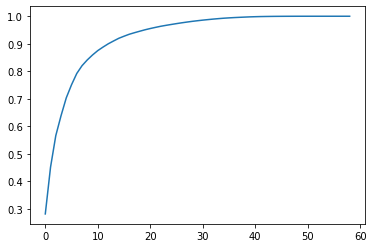

In [175]:
from sklearn.decomposition import PCA

pca = PCA()
# print(p_df.head())
# len(pca.components_)
pca.fit(tr_inputs)
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);
# print(cdf[:15]) # 15 most explaining components
pca = PCA(n_components=18) # Looks to about how many components explains 95% of the total variance.
comps = pca.fit_transform(tr_inputs)
p_df = pd.DataFrame(comps)
p_df.shape

In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


regr = RandomForestRegressor()

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

regr = RandomizedSearchCV(estimator = regr, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2)

from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(8, 32, 16), 
                   activation='relu',
                   solver = 'adam',
                   alpha = 1e-1,
                   learning_rate='adaptive',
                   learning_rate_init=2.25e-5,
                   max_iter=35000,
                   random_state = 42,
                   shuffle=False).fit(p_df, tr_target)

pca_test = pca.transform(ts_inputs)
p_test = pd.DataFrame(pca_test)

est_out = clf.predict(p_test)

R_2 = r2_score(ts_target, est_out)

R_2

-0.8368883048989924

In [154]:
# for (i, _) in df.iteritems():
#     print(df[i].value_counts())

In [177]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

pca_test = pca.transform(ts_inputs)
p_test = pd.DataFrame(pca_test)
# print(p_test.shape)
model_SVR = SVR(C=1.0, epsilon=0.2)
print(tr_inputs.shape)
model_SVR.fit(p_df, tr_target)
est_out_svm = model_SVR.predict(p_test)
print("R2 score:", r2_score(ts_target, est_out_svm))


(249, 59)
R2 score: -1.0501041615581932


In [178]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(ts_target, est_out_svm))
print("RMSE:", rmse)
print("mean and std of targets:", np.mean(ts_target), np.std(ts_target))

RMSE: 9.596514032859412
mean and std of targets: 11.911943928439022 6.702325862171413


In [110]:
est_out_svm

array([ 7.32528564,  4.05967819,  4.49630203,  0.35575135,  8.6546077 ,
        9.56696068,  5.46667222, 13.6009818 ,  5.09078199, 14.21014084,
       12.6127393 ,  8.22381067,  0.95308453,  0.07004595,  2.46690822,
        4.69181838,  6.90212741,  6.65772994,  1.51314104,  3.94625506,
        4.25998179,  5.5576448 ,  7.54116421,  8.2791104 ,  5.13337423,
       10.06643835,  0.36929052,  0.30436386,  6.49031033,  7.18900378,
       10.35428745,  1.31178904,  4.14051446,  5.5428264 ,  1.42807879,
        3.138044  ,  1.18091641,  3.8412604 ,  0.87986978,  6.0743555 ,
        5.65457358,  3.02560062,  6.9236103 ,  7.69119088,  0.95383838,
        4.93554685,  7.34172287,  2.00114289,  8.59882033,  5.94126175,
        0.21454983,  4.6042168 , 12.36930708,  5.9786258 ,  4.20326899,
        7.10793801,  4.9686041 ,  3.42034457,  2.81751902,  0.56111396,
        2.21001742,  8.01800757, 12.64253499,  0.8148062 ,  6.05788835,
        9.17470417,  7.55835965,  5.30953793,  5.39060814, 13.94

In [6]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.1,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (8, 32, 16),
 'learning_rate': 'adaptive',
 'learning_rate_init': 2.25e-05,
 'max_fun': 15000,
 'max_iter': 35000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': False,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}